In [15]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
train_dir = "/content/drive/MyDrive/FruitinAmazon/train"
test_dir = "/content/drive/MyDrive/FruitinAmazon/test"

In [18]:
import os
class_names = sorted(os.listdir(train_dir))
if not class_names:
  print("No class directories found in the train folder!")
else:
  print(f"Found {len(class_names)} classes: {class_names}")

Found 6 classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


In [19]:

corrupted_images = []  # List to store corrupted image paths

# Loop through each class folder and check for corrupted images
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):  # Ensure it's a valid directory
        images = os.listdir(class_path)
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Verify image integrity
            except (IOError, UnidentifiedImageError):
                corrupted_images.append(img_path)

# Print results
if corrupted_images:
    print("\nCorrupted Images Found:")
    for img in corrupted_images:
        print(img)
else:
    print("\nNo corrupted images found.")



No corrupted images found.


In [20]:
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(images)

print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
    print(f"{class_name:<25}{count:>15}")
print("=" * 45)



Class Distribution:
Class Name               Valid Image Count
acai                                  15
cupuacu                               15
graviola                              15
guarana                               15
pupunha                               15
tucuma                                15


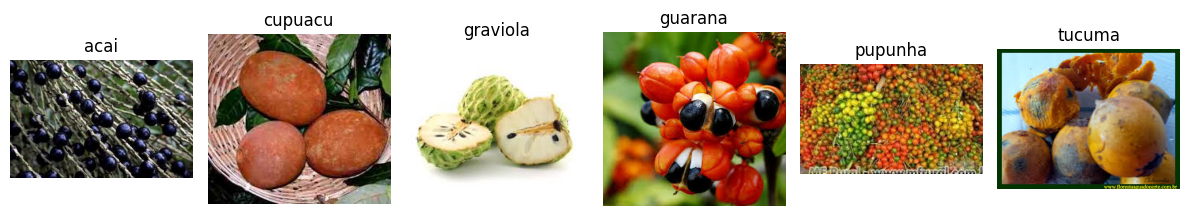

In [21]:


selected_images = []
selected_labels = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:
            selected_img = os.path.join(class_path, random.choice(images))
            selected_images.append(selected_img)
            selected_labels.append(class_name)

num_classes = len(selected_images)
fig, axes = plt.subplots(1,num_classes, figsize=(12,6))

if num_classes == 1:
    axes = [axes]

for ax, img_path, label in zip(axes, selected_images, selected_labels):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [22]:
# Define image size and batch size
img_height = 224
img_width = 224
batch_size = 64


# Load training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    label_mode='categorical',
    seed=123
)

# Load test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
)

# Verify class names and number of classes
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")




Found 90 files belonging to 6 classes.
Found 30 files belonging to 6 classes.
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Number of classes: 6


In [23]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [24]:

from tensorflow.keras.layers import LeakyReLU

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    for filters in [32, 64, 128, 256]:
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.15)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

model = make_model(input_shape=(224, 224, 3), num_classes=num_classes)
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 28, 28, 256)         │           1,0

 Total params: 491,334 (1.87 MB)

 Trainable params: 489,606 (1.87 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [25]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
# Callbacks
checkpoint = ModelCheckpoint('best_model_task1.h5', monitor='val_accuracy', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train
history = model.fit(
    train_ds,
    epochs=250,
    batch_size = batch_size,
    validation_data=test_ds,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2405 - loss: 2.2309  

2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 8s/step - accuracy: 0.2529 - loss: 2.1918 - val_accuracy: 0.2000 - val_loss: 1.7892
Epoch 2/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2561 - loss: 2.1577  

2/2 ━━━━━━━━━━━━━━━━━━━━ 26s 10s/step - accuracy: 0.2633 - loss: 2.1274 - val_accuracy: 0.3000 - val_loss: 1.7784
Epoch 3/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 10s/step - accuracy: 0.4377 - loss: 1.6133 - val_accuracy: 0.3000 - val_loss: 1.7681
Epoch 4/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5045 - loss: 1.3767  

2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 9s/step - accuracy: 0.4956 - loss: 1.3839 - val_accuracy: 0.3333 - val_loss: 1.7587
Epoch 5/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 8s/step - accuracy: 0.4443 - loss: 1.4430 - val_accuracy: 0.2667 - val_loss: 1.7481
Epoch 6/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.5475 - loss: 1.2278 - val_accuracy: 0.2333 - val_loss: 1.7427
Epoch 7/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 10s/step - accuracy: 0.6105 - loss: 1.0776 - val_accuracy: 0.2000 - val_loss: 1.7451
Epoch 8/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 51s 15s/step - accuracy: 0.6336 - loss: 1.0353 - val_accuracy: 0.2000 - val_loss: 1.7499
Epoch 9/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 32s 8s/step - accuracy: 0.6728 - loss: 0.8626 - val_accuracy: 0.1667 - val_loss: 1.7502
Epoch 10/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 10s/step - accuracy: 0.5927 - loss: 1.0650 - val_accuracy: 0.1667 - val_loss: 1.7559
Epoch 11/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 26s 10s/step - accuracy: 0.6358 - loss: 1.0268 - val_accuracy: 0.1667 - val_loss: 1.7659
Epoch 

In [27]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2333 - loss: 1.7427
Test accuracy: 0.2333
Test loss: 1.7427


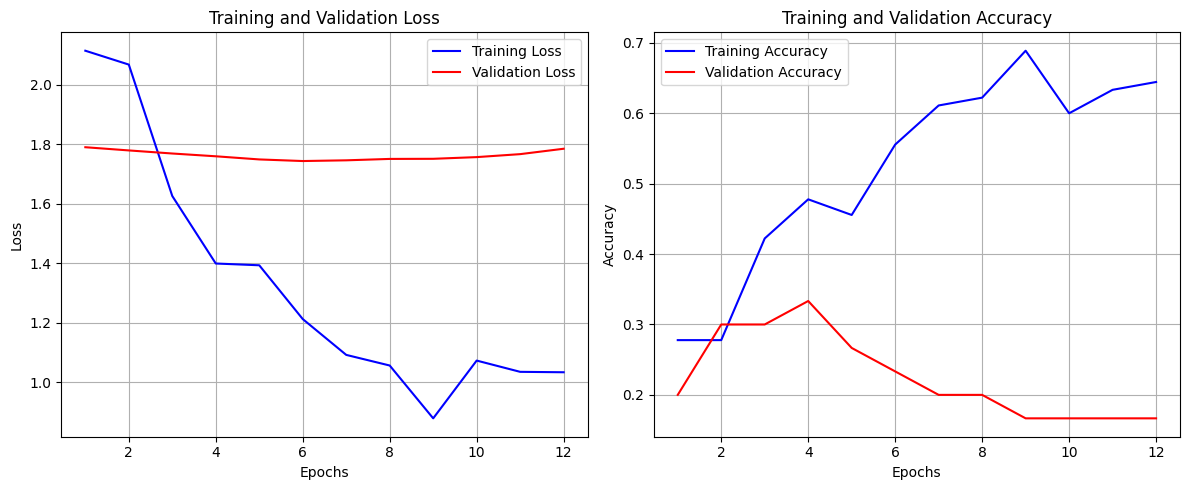

In [28]:
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Create subplots: 1 row, 2 columns
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [29]:
model.save('SujalPrajapati_w6_task1.h5')
print("Model saved as 'SujalPrajapati_w6_task1.h5'")

Model saved as 'SujalPrajapati_w6_task1.h5'


In [30]:

loaded_model = tf.keras.models.load_model('SujalPrajapati_w6_task1.h5')
loaded_test_loss, loaded_test_acc = loaded_model.evaluate(test_ds)
print(f"Loaded model test accuracy: {loaded_test_acc:.4f}")
print(f"Loaded model test loss: {loaded_test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2333 - loss: 1.7427
Loaded model test accuracy: 0.2333
Loaded model test loss: 1.7427


In [31]:
loaded_model = keras.models.load_model('SujalPrajapati_w6_task1.h5')
print("Model loaded for predictions")

# Collect all test images and labels
all_images = []
all_labels = []
for images, labels in test_ds:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

# Concatenate batches into single arrays
test_images = np.concatenate(all_images, axis=0)  # Shape: (30, 128, 128, 3)
test_labels_onehot = np.concatenate(all_labels, axis=0)  # Shape: (30, 6)

# Make predictions
predictions = loaded_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_onehot, axis=1)


print(f"Class names: {class_names}")

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", report)

Model loaded for predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Classification Report:
               precision    recall  f1-score   support

        acai       0.00      0.00      0.00         5
     cupuacu       0.20      1.00      0.33         5
    graviola       0.00      0.00      0.00         5
     guarana       0.00      0.00      0.00         5
     pupunha       1.00      0.20      0.33         5
      tucuma       0.25      0.20      0.22         5

    accuracy                           0.23        30
   macro avg       0.24      0.23      0.15        30
weighted avg       0.24      0.23      0.15        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [32]:
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model_vgg = keras.Model(inputs=base_model.input, outputs=outputs)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [33]:
model_vgg.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history_vgg = model_vgg.fit(
    train_ds,
    epochs=50,
    validation_data=test_ds,
    callbacks=[ModelCheckpoint('best_model_task2.h5', monitor='val_accuracy', save_best_only=True),
               EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.2104 - loss: 4.4416 

2/2 ━━━━━━━━━━━━━━━━━━━━ 80s 39s/step - accuracy: 0.2181 - loss: 4.6095 - val_accuracy: 0.5333 - val_loss: 5.2466
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.6191 - loss: 4.2595 

2/2 ━━━━━━━━━━━━━━━━━━━━ 75s 37s/step - accuracy: 0.6275 - loss: 4.0869 - val_accuracy: 0.6667 - val_loss: 2.4835
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 83s 36s/step - accuracy: 0.8538 - loss: 0.9202 - val_accuracy: 0.6333 - val_loss: 2.7722
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 80s 36s/step - accuracy: 0.9095 - loss: 0.3386 - val_accuracy: 0.6333 - val_loss: 4.3567
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.8764 - loss: 0.5261 

2/2 ━━━━━━━━━━━━━━━━━━━━ 110s 57s/step - accuracy: 0.8769 - loss: 0.5081 - val_accuracy: 0.7333 - val_loss: 2.5031
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.9733 - loss: 0.1174  

2/2 ━━━━━━━━━━━━━━━━━━━━ 117s 37s/step - accuracy: 0.9748 - loss: 0.1110 - val_accuracy: 0.7667 - val_loss: 1.7346
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 80s 36s/step - accuracy: 0.9800 - loss: 0.0433 - val_accuracy: 0.7333 - val_loss: 1.5282
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 74s 34s/step - accuracy: 0.9926 - loss: 0.0188 - val_accuracy: 0.6667 - val_loss: 1.5982
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 82s 36s/step - accuracy: 1.0000 - loss: 0.0083 - val_accuracy: 0.6667 - val_loss: 1.7428
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 75s 36s/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.7333 - val_loss: 1.9000
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 86s 36s/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.7333 - val_loss: 2.0403
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 80s 36s/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.7333 - val_loss: 2.1546
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 76s 36s/step - accuracy: 1.0000 - loss: 8.8237e-04 - val_accuracy: 0.7333 - val_loss: 2.2488
Ep

In [34]:
# Evaluate
test_loss_vgg, test_acc_vgg = model_vgg.evaluate(test_ds)
print(f"Test accuracy for VGG16: {test_acc_vgg:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.7333 - loss: 1.5282
Test accuracy for VGG16: 0.7333


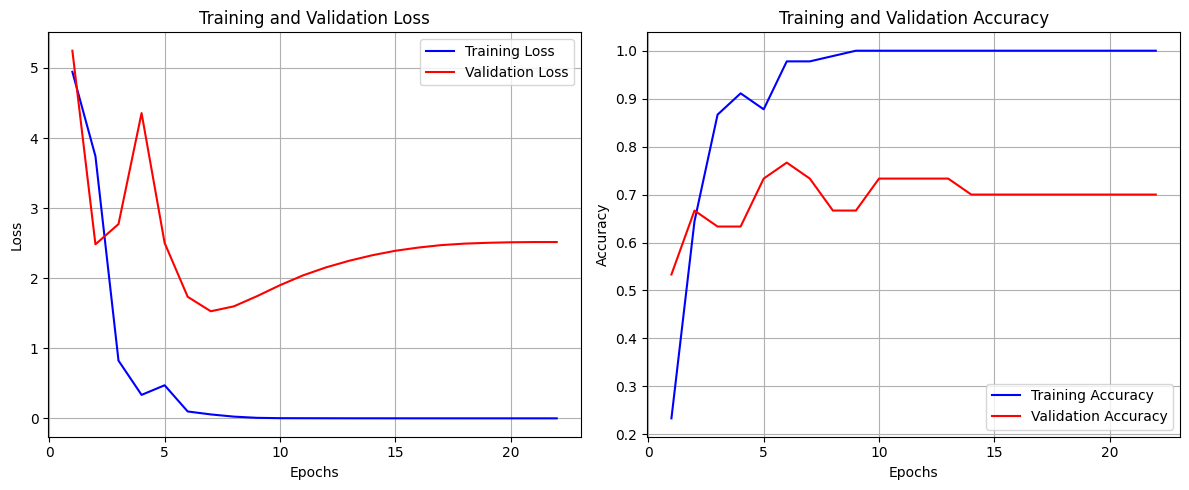

In [35]:
history_dict = history_vgg.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Create subplots: 1 row, 2 columns
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [36]:

predictions_vgg = model_vgg.predict(test_ds)
y_pred_vgg = np.argmax(predictions_vgg, axis=1)

# Classification Report
print("Classification Report for Task 2 (VGG16):")
print(classification_report(true_labels, y_pred_vgg, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
Classification Report for Task 2 (VGG16):
              precision    recall  f1-score   support

        acai       0.57      0.80      0.67         5
     cupuacu       0.80      0.80      0.80         5
    graviola       1.00      0.80      0.89         5
     guarana       1.00      1.00      1.00         5
     pupunha       1.00      0.40      0.57         5
      tucuma       0.43      0.60      0.50         5

    accuracy                           0.73        30
   macro avg       0.80      0.73      0.74        30
weighted avg       0.80      0.73      0.74        30

